In [173]:
# Data processing
import numpy as np
import pandas as pd

# Download data
import yfinance as yf

from scipy.stats import norm
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [140]:
# Initial investment and currency per stock

# in dollar values initially?

initial_investment = 100000000 #100mil

# initial weights
weights = np.array([0.2,0.2,0.2,0.2,0.2])

investment = {
    "DBA" : [20000000, 'USD'], # iPath Pure Beta Broad Commodity ETN (BCM)
    "^HSI" : [20000000, 'USD'], # Hang Seng Index
    "^AEX"  : [20000000, 'EUR'], # AEX Index
    "^GSPC" : [20000000, 'USD'], # S&P 500 Index
    "^N225" : [20000000, 'JPY'] # Nikkei 225
}

start = "2010-01-01"
end = "2018-12-31"

In [127]:
investment.values()

dict_values([[1000000, 'USD'], [2500000, 'USD'], [500000, 'EUR'], [2300000, 'USD'], [1750000, 'JPY']])

In [83]:
# Download data and store in dataframe

instruments_data = yf.download(' '.join(list(investment.keys())), start=start, end=end, groupby='ticker')
instruments = instruments_data['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [84]:
instruments.tail()

,DBA,^AEX,^GSPC,^HSI,^N225
Date,,,,,
2018-12-24,16.687899,478.339996,2351.100098,25651.380859,NaN
2018-12-25,NaN,NaN,NaN,NaN,19155.740234
2018-12-26,16.697742,NaN,2467.699951,NaN,19327.060547
2018-12-27,16.638670,476.029999,2488.830078,25478.880859,20077.619141
2018-12-28,16.707588,484.170013,2485.739990,25504.199219,20014.769531


In [85]:
# Create exchange rate ticker list based on initial investment data
currencies = list(set(['EUR' + i[1] + '=X' for i in investment.values()]))

# Remove EUR-EUR exchange rate
for currency in currencies:
    if currency[0:2] == currency[3:5]:
        currencies.remove(currency)
        
currencies = " ".join(currencies)

In [86]:
currencies

'EURUSD=X EURJPY=X'

In [87]:
# Download exchange rate data
exchangerate_data = yf.download(currencies, start=start, end=end, groupby='ticker')
exchangerate = exchangerate_data['Adj Close']
exchangerate.tail()

[*********************100%***********************]  2 of 2 completed


,EURJPY=X,EURUSD=X
Date,,
2018-12-24,126.292000,1.137281
2018-12-25,125.769997,1.140394
2018-12-26,126.001999,1.141553
2018-12-27,126.404999,1.136131
2018-12-28,126.767998,1.143105


In [88]:
# Scrape EURIBOR rates

import csv
import requests
import io

year_range = int(end[0:4]) - int(start[0:4]) + 1
years = range(int(start[0:4]), int(start[0:4]) + year_range)

urls = ['https://www.emmi-benchmarks.eu/assets/components/rateisblue/file_processing/publication/processed/hist_EURIBOR_{}.csv'
        .format(i) for i in range(int(start[0:4]), int(start[0:4]) + year_range)]

for url in urls:
    s = requests.get(url).content
    if url == urls[0]:
        euribor = pd.read_csv(io.StringIO(s.decode('utf-8'))).transpose()
    else:
        euribor = euribor.append(pd.read_csv(io.StringIO(s.decode('utf-8'))).transpose())
        
error_lines = ['Unnamed: 0', 'Unnamed: 261']

euribor3m = euribor[~euribor.index.isin(error_lines)][5]

In [89]:
# Make index datetime
euribor3m.index = pd.to_datetime(euribor3m.index, format='%d/%m/%Y')

In [90]:
# holding 10% in cash

euribor3m

2010-01-04      0.7
2010-01-05    0.699
2010-01-06    0.694
2010-01-07    0.692
2010-01-08    0.691
              ...  
2018-12-21   -0.238
2018-12-24   -0.237
2018-12-27   -0.237
2018-12-28   -0.236
2018-12-31   -0.237
Name: 5, Length: 2306, dtype: object

In [91]:
# invest in stock (and commodity) indices (by investing in mutual funds)? ETFs?


instruments

,DBA,^AEX,^GSPC,^HSI,^N225
Date,,,,,
2009-12-31,25.755527,NaN,1115.099976,NaN,NaN
2010-01-04,25.999054,343.029999,1132.989990,21823.279297,10654.790039
2010-01-05,26.164654,342.019989,1136.520020,22279.580078,10681.830078
2010-01-06,26.310770,341.480011,1137.140015,22416.669922,10731.450195
2010-01-07,26.106207,340.549988,1141.689941,22269.449219,10681.660156
...,...,...,...,...,...
2018-12-24,16.687899,478.339996,2351.100098,25651.380859,NaN
2018-12-25,NaN,NaN,NaN,NaN,19155.740234
2018-12-26,16.697742,NaN,2467.699951,NaN,19327.060547


In [92]:
# for exchange rate conversion

exchangerate

,EURJPY=X,EURUSD=X
Date,,
2009-12-31,133.149994,1.432706
2010-01-01,133.710007,1.438994
2010-01-04,133.389999,1.442398
2010-01-05,131.529999,1.436596
2010-01-06,133.013000,1.440403
...,...,...
2018-12-24,126.292000,1.137281
2018-12-25,125.769997,1.140394
2018-12-26,126.001999,1.141553


### Step2: 
Implement and backtest VaR and ES for the two abovementioned confidence levels and 1-day horizon using the following methods:

In [93]:
from functools import reduce

In [116]:
# merge the instrument prices, exchange rates, and euribor into one dataframe
dfs = [instruments, exchangerate, euribor3m]
df_pf = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)
df_pf = df_pf.rename(columns={5: 'euribor3m', '^AEX':'AEX', '^GSPC':'GSPC','^N225':'N225', '^HSI':'HSI'})
df_pf['euribor3m'] = pd.to_numeric(df_pf['euribor3m'])

In [111]:
instrument_names = df_pf.columns[:5]
instrument_names

Index(['DBA', 'AEX', 'GSPC', 'HSI', 'N225'], dtype='object')

#### Estimate VaR and ES, based on Variance-Covariance method, multivariate normal distribution

In [185]:
df_returns_all = np.log(df_pf[instrument_names])- np.log(df_pf[instrument_names].shift())

In [186]:
# select the estimation period
df_returns = df_returns_all[:]

In [187]:
# calculate the variance-covariance matrix
cov_matrix = df_returns.cov()
cov_matrix

,DBA,AEX,GSPC,HSI,N225
DBA,0.000066,0.000021,0.000023,0.000012,0.000012
AEX,0.000021,0.000114,0.000064,0.000048,0.000047
GSPC,0.000023,0.000064,0.000091,0.000022,0.000022
HSI,0.000012,0.000048,0.000022,0.000129,0.000081
N225,0.000012,0.000047,0.000022,0.000081,0.000178


In [188]:
# calculate the mean return
avg_returns = df_returns.mean()

In [189]:
# calcuclate the portfolio mean
pf_mean_pct = sum(avg_returns*weights)
pf_mean_pct

0.00012677748676323699

In [190]:
# calculate the portfolio standard deviation in percentage terms

pf_std_pct = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

In [191]:
# convert the pf return and std from percentage to euro
pf_mean_euro = pf_mean_pct * initial_investment
pf_std_euro = pf_std_pct * initial_investment

In [192]:
confidence_levels = [0.975, 0.99]
alphas = [0.025,0.01]
alphas

[0.025, 0.01]

In [193]:
# calculate the VaR
var_975_1d = norm.ppf(confidence_levels[0]) * pf_std_euro - pf_mean_euro
es_975_1d = alphas[0]**-1 * norm.pdf(norm.ppf(alphas[0]))*pf_std_euro - pf_mean_euro

In [194]:
# var_990_1d = norm.ppf(confidence_levels[1], pf_mean_euro, pf_std_euro)
# var_990_1d

In [195]:
var_990_1d = norm.ppf(confidence_levels[1]) * pf_std_euro - pf_mean_euro
es_990_1d = alphas[1]**-1 * norm.pdf(norm.ppf(alphas[1]))*pf_std_euro - pf_mean_euro

In [196]:
print(f'VaR 99% 1d: {var_990_1d}, ES 99% 1d: {es_990_1d}')

VaR 99% 1d: 1651657.5870184936, ES 99% 1d: 1894092.1947255149


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.000e+00, 1.400e+01, 7.000e+01, 3.660e+02, 1.281e+03, 4.780e+02,
        7.300e+01, 1.000e+01, 0.000e+00, 1.000e+00]),
 array([-0.05873132, -0.04578596, -0.0328406 , -0.01989524, -0.00694988,
         0.00599549,  0.01894085,  0.03188621,  0.04483157,  0.05777693,
         0.07072229]),
 <a list of 10 Patch objects>)

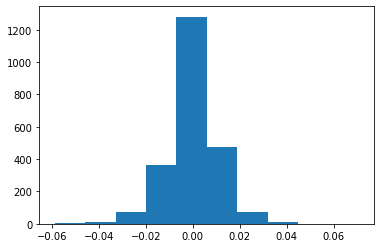

In [197]:
plt.hist(df_returns['AEX'])

#### Estimate VaR and ES, based on Variance-Covariance method, Student-t distribution with 3, 4, 5, 6 degrees of freedom

In [198]:
from scipy.stats import t

In [203]:
degree_of_freedom = [3,4,5,6]

In [217]:
# at 97.5% confidence level
for df in degree_of_freedom:
    
    xanu = t.ppf(alphas[0], df)
    
    var_975_1d_t= t.ppf(confidence_levels[0], df) * pf_std_euro - pf_mean_euro
    
    es_975_1d_t = -1/alphas[0] * (1-df)**(-1) * (df-2+xanu**2) * t.pdf(xanu, df)*pf_std_euro - pf_mean_euro
    
    
    print(f'VaR 97.5% 1d: {np.round(var_975_1d_t,3)}, ES 97.5% 1d: {np.round(es_975_1d_t,3)}')

VaR 97.5% 1d: 2264134.717, ES 97.5% 1d: 3043503.6
VaR 97.5% 1d: 1973669.929, ES 97.5% 1d: 2356393.198
VaR 97.5% 1d: 1826389.5, ES 97.5% 1d: 2072668.384
VaR 97.5% 1d: 1737912.478, ES 97.5% 1d: 1928199.237


In [218]:
# compare with VaR and ES under standard normal distribution
print(f'VaR 97.5% 1d: {np.round(var_975_1d,3)}, ES 97.5% 1d: {np.round(es_975_1d,3)}')

VaR 97.5% 1d: 1389536.147, ES 97.5% 1d: 1659852.761


In [219]:
# at 99% confidence level
for df in degree_of_freedom:
    
    xanu = t.ppf(alphas[1], df)
    
    var_990_1d_t= t.ppf(confidence_levels[1], df) * pf_std_euro - pf_mean_euro
    
    es_990_1d_t = -1/alphas[1] * (1-df)**(-1) * (df-2+xanu**2) * t.pdf(xanu, df)*pf_std_euro - pf_mean_euro
    
    
    print(f'VaR 99% 1d: {np.round(var_975_1d_t,3)}, ES 99% 1d: {np.round(es_975_1d_t,3)}')

VaR 97.5% 1d: 1737912.478, ES 97.5% 1d: 1928199.237
VaR 97.5% 1d: 1737912.478, ES 97.5% 1d: 1928199.237
VaR 97.5% 1d: 1737912.478, ES 97.5% 1d: 1928199.237
VaR 97.5% 1d: 1737912.478, ES 97.5% 1d: 1928199.237


In [220]:
# compare with VaR and ES under standard normal distribution
print(f'VaR 99% 1d: {np.round(var_990_1d,3)}, ES 99% 1d: {np.round(es_990_1d,3)}')

VaR 99% 1d: 1651657.587, ES 99% 1d: 1894092.195


#### Estimate VaR and ES, based on Historical Simulation method

In [275]:
# calculate the historical losses, and order them in increasing order

df_returns = df_returns_all[:] # select estimation period
pf_losses = np.sort(initial_investment * df_returns.dot(weights))

In [276]:
pf_losses

array([-4579307.24322569, -4439661.3214782 , -3989910.78990434, ...,
                     nan,               nan,               nan])

In [277]:
# at 97.5% confidence level
var_975_1d_hsm = pf_losses[int(alphas[0]*len(pf_losses))]
es_975_1d_hsm = pf_losses[0:int(alphas[0]*len(pf_losses))].mean()

In [278]:
print(f'VaR 97.5% 1d: {np.round(var_975_1d_hsm,3)}, ES 97.5% 1d: {np.round(es_975_1d_hsm,3)}')

VaR 97.5% 1d: -1448621.913, ES 97.5% 1d: -2096646.549


In [279]:
# at 99% confidence level
var_990_1d_hsm = pf_losses[int(alphas[1]*len(pf_losses))]
es_990_1d_hsm = pf_losses[0:int(alphas[1]*len(pf_losses))].mean()

In [280]:
print(f'VaR 99% 1d: {np.round(var_990_1d_hsm,3)}, ES 99% 1d: {np.round(es_990_1d_hsm,3)}')

VaR 99% 1d: -1983659.942, ES 99% 1d: -2670225.739


#### Estimate VaR and ES, based on Constant Conditional Correlation method

#### Estimate VaR and ES, based on Filtered Historical Simulation method with EWMA for each risk factor